![image.png](https://images.unsplash.com/photo-1584036561566-baf8f5f1b144?ixid=MXwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHw%3D&ixlib=rb-1.2.1&auto=format&fit=crop&w=1189&q=80)
Photo by <a href="https://unsplash.com/@fusion_medical_animation?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Fusion Medical Animation</a> on <a href="https://unsplash.com/s/photos/covid?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
  
  

# COVID-19 Radiography Database 


> "Recently, several groups have reported deep machine learning techniques using X-ray images for detecting COVID-19 pneumonia ... However, most of these groups used rather a small dataset containing only a few COVID-19 samples. This makes it difficult to generalize their results reported in these articles and cannot guarantee that the reported performance will retain when these models will be tested on a larger dataset"<br>
[-M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, M. T. Islam, “Can AI help in screening Viral and COVID-19 pneumonia?” IEEE Access, Vol. 8, 2020, pp. 132665 - 132676.](https://ieeexplore.ieee.org/document/9144185).


This notebook uses ML to predict positive cases of Covid-19 given X-ray images. Since the first publication in March 2020, this dataset continues to updated fed with additional images making it an exciting ML problem.

## <center style="background-color:Gainsboro; width:40%;">Contents</center>
1.[Overview](#1.-Overview)<br>
1.1.[Content](#1.1.-Content)<br>
1.2.[Acknowledgements](#1.2.-Acknowledgements)<br>
2.[The Data](#2.-The-Data)<br>
2.1[Image Data EDA](#2.-Image-Data-EDA)<br>
3.[Model](#3.-Model)<br>
4.[Results and Conclusion](#4.-Results-and-Conclusion)<br>

***Please remember to upvote if you find this Notebook helpful!***

# 1. Overview

The coronavirus pandemic has produced thousands of causalities and affected millions of people globally. Any technological device allowing accelerated screening of the COVID-19 infection with high accuracy can be crucially helpful to healthcare professionals. 

According to [1],  X-ray imaging is an easily accessible tool that is used to diagnose COVID-19 cases. However, though regular Chest X-Ray (XCR) images may improve early screening of suspected cases, the images of various viral cases of pneumonia are similar. Therefore, it is difficult for radiologists to distinguish COVID-19 from other viral cases of pneumonia. 

This database and ongoing research are performed to investigate the utility of artificial intelligence (AI) in the rapid and accurate detection of COVID-19 from chest X-ray images.

# 1.1 Content

In total, there are 21165 samples divided into four main classes:
* Covid-19
* Lung Opacity
* Normal
* Viral Pneumonia


All the images are in Portable Network Graphics (PNG) file format and the resolution are 299x299 pixels. On this current update, the database currently holds 3,616 COVID-19 positive cases, 10,192 Normal, 6,012 Lung Opacity (Non-COVID lung infection), and 1,345 Viral Pneumonia images.

# 1.2 Acknowledgments

The database creators acknowledge several institutions and researchers that have made the data collection possible. Please see [here](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) for the full list of colaborators.

# 2. The Data

First, let's organise the data into a dataframe to group the path of all images and their respective target. By doing so it is easier to handle data transformations later on. In my opinion, this method is more straightforward than handling the images in different folders.

>Import Libraries and Modules

In [2]:
# Data preprocessing
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from glob import glob
from PIL import Image
import os
import random
import cv2
#Model
import keras
from keras.models import Sequential, Model,load_model
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPooling2D,MaxPool2D,AveragePooling2D,GlobalMaxPooling2D
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras import regularizers
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator,array_to_img
from keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from keras.metrics import PrecisionAtRecall,Recall 
#Model Analysis
from sklearn.metrics import confusion_matrix

>Data import 

In [3]:
path = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/'

diag_code_dict = {
    'COVID': 0,
    'Lung_Opacity': 1,
    'Normal': 2,
    'Viral Pneumonia': 3}

diag_title_dict = {
    'COVID': 'Covid-19',
    'Lung_Opacity': 'Lung Opacity',
    'Normal': 'Healthy',
    'Viral Pneumonia': 'Viral Pneumonia'}

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(path, '*','*.png'))}

covidData = pd.DataFrame.from_dict(imageid_path_dict, orient = 'index').reset_index()
covidData.columns = ['image_id','path']
classes = covidData.image_id.str.split('-').str[0]
covidData['diag'] = classes
covidData['target'] = covidData['diag'].map(diag_code_dict.get) 
covidData['Class'] = covidData['diag'].map(diag_title_dict.get) 

In [4]:
samples,features = covidData.shape
duplicated = covidData.duplicated().sum()
null_values = covidData.isnull().sum().sum()

print('Basic EDA')
print('Number of samples: %d'%(samples))
print('Number of duplicated values: %d'%(duplicated))
print('Number of Null samples: %d' % (null_values))

Basic EDA
Number of samples: 21165
Number of duplicated values: 0
Number of Null samples: 0


Complementary information on Age, Gender or Weight of patients samples could be helpful to make the EDA more interesting. Not to mention, that additional information could be extremly important for the Machine Learning model.

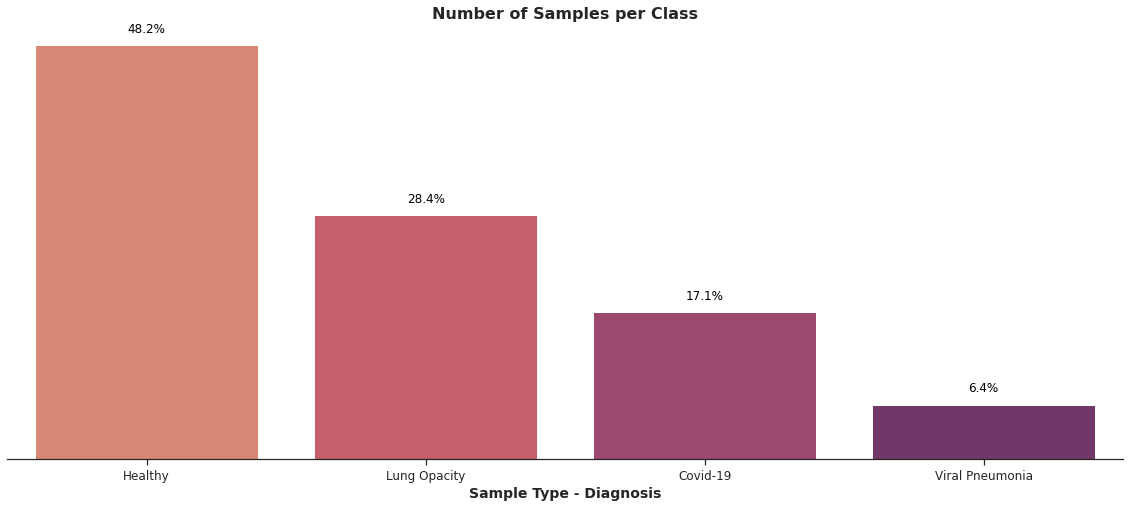

In [5]:
#Samples per class
plt.figure(figsize=(20,8))
sns.set(style="ticks", font_scale = 1)
ax = sns.countplot(data = covidData,x='Class',order = covidData['Class'].value_counts().index,palette="flare")
sns.despine(top=True, right=True, left=True, bottom=False)
plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Sample Type - Diagnosis',fontsize = 14,weight = 'bold')
ax.set(yticklabels=[])
ax.axes.get_yaxis().set_visible(False) 
plt.title('Number of Samples per Class', fontsize = 16,weight = 'bold');
#Plot numbers
for p in ax.patches:
    ax.annotate("%.1f%%" % (100*float(p.get_height()/samples)), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
    ha='center', va='bottom', color='black', xytext=(0, 10),rotation = 'horizontal',
    textcoords='offset points')

* Healthy and Lung Opacity samples compose 80% of the dataset
* For this application, the main goal is to recognise Covid-19 patients. It will be interesting to see if the model will have greater difficulty in identifying Pneumonia or Covid samples
* Similar to other health conditions prediction problems or unbalanced datasets, it is necessary to prioritise Precision or Recall, since Accuracy can be misleading. The F1-Score is also a reasonable option

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
<h3>What we know so far</h3>
<ul>
<li>Our dataset contains a reasonable number of images 
<li>No data cleansing is required
<li>Exploratory Data Analysis is done with regards to metadata, as we do not have additional information from the patients
<li>We can investigate image patterns and relantionships between the classes
<li>The data is unbalanced with almost 50% of samples belongs to <em>"Healthy"</em> class. The model will probably present better performance towards these samples
<li> Due to the Data Unbalance, it is best to use metrics such as <em>Precision</em>, <em>Recall</em> or <em>F1-Score</em> to measure model performance
<ul>
</blockquote>

## 2.1 Image Data EDA

In this section, an EDA on the image data is presented. Here it is investigated any patterns/relationships regarding the images and their respective classes.

First, let's have a look at a random sample and extract basic information regarding the images:

> Add images to DF

In [6]:
covidData['image'] = covidData['path'].map(lambda x: np.asarray(Image.open(x).resize((75,75))))

> Plot Samples

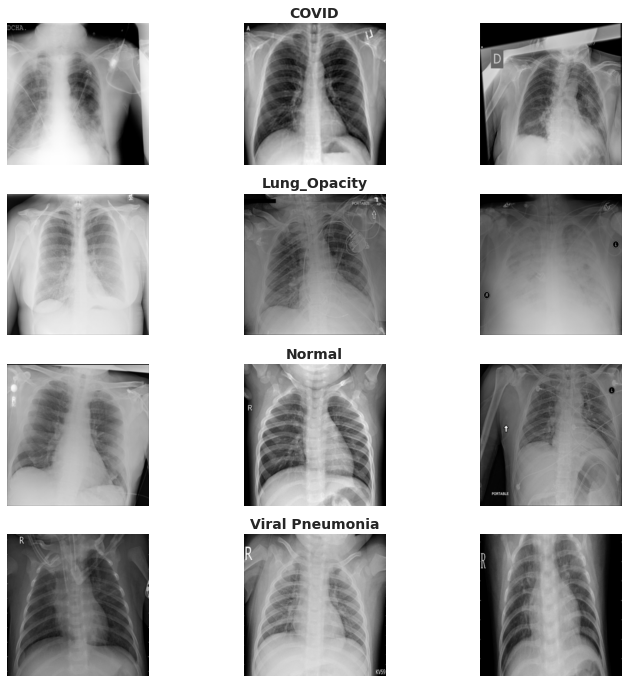

In [7]:
#Image Sampling
n_samples = 3

fig, m_axs = plt.subplots(4, n_samples, figsize = (4*n_samples, 3*4))

for n_axs, (type_name, type_rows) in zip(m_axs,covidData.sort_values(['diag']).groupby('diag')):
    n_axs[1].set_title(type_name,fontsize = 14,weight = 'bold')
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):       
        picture = c_row['path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')

In an RGB image, each pixel is represented by three 8 bit numbers associated with the values for Red, Green, Blue respectively. The numbers range from 0 to 255 for the three different channels.

The dataset presents the images as *.PNG*. Using the *cv2* library, the colour of the images are properly displayed.

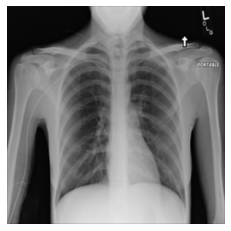

In [8]:
plt.figure()
pic_id = random.randrange(0, samples)
picture = covidData['path'][pic_id]
image = cv2.imread(picture)
plt.imshow(image)
plt.axis('off');
plt.show()      

>Checking the image basic parameters

In [9]:
print('Shape of the image : {}'.format(image.shape))
print('Image Hight {}'.format(image.shape[0]))
print('Image Width {}'.format(image.shape[1]))
print('Dimension of Image {}'.format(image.ndim))
print('Image size {}'.format(image.size))
print('Image Data Type {}'.format(image.dtype))
print('Maximum RGB value in this image {}'.format(image.max()))
print('Minimum RGB value in this image {}'.format(image.min()))

Shape of the image : (299, 299, 3)
Image Hight 299
Image Width 299
Dimension of Image 3
Image size 268203
Image Data Type uint8
Maximum RGB value in this image 255
Minimum RGB value in this image 0


Even though the images are in greyscale, they present the three channels. 

The output below is an unique pixel of the **image array at [0,0]**, we see that all colour channels have the same value. 
>As a side note, OpenCV assumes the image to be Blue-Green-Red (BGR), not RGB.

In [10]:
image[0,0]

array([19, 19, 19], dtype=uint8)

A visualisation of the image selecting only one of the three channels is shown next. As all channels contain the same values, the pictures are the same for the three single channels.

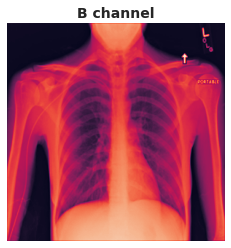

In [11]:
plt.title('B channel',fontsize = 14,weight = 'bold')
plt.imshow(image[ : , : , 0])
plt.axis('off');
plt.show()

As it was shown so far, the images are nothing more than an array of numbers in a format [Height, Width, Channel]. With that in mind, we proceed with our EDA.

Here we start to examine if there is any pattern between the image colour values and their class. A distribution plot illustrates how the mean, max and min colour values are presented for the dataset.

In [12]:
mean_val = []
std_dev_val = []
max_val = []
min_val = []

for i in range(0,samples):
    mean_val.append(covidData['image'][i].mean())
    std_dev_val.append(np.std(covidData['image'][i]))
    max_val.append(covidData['image'][i].max())
    min_val.append(covidData['image'][i].min())

imageEDA = covidData.loc[:,['image', 'Class','path']]
imageEDA['mean'] = mean_val
imageEDA['stedev'] = std_dev_val
imageEDA['max'] = max_val
imageEDA['min'] = min_val

subt_mean_samples = imageEDA['mean'].mean() - imageEDA['mean']
imageEDA['subt_mean'] = subt_mean_samples

>kde plots

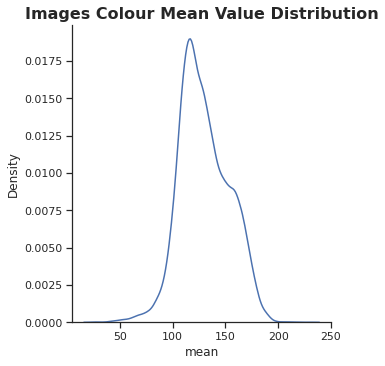

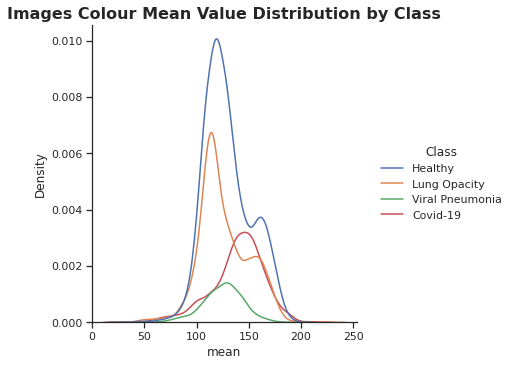

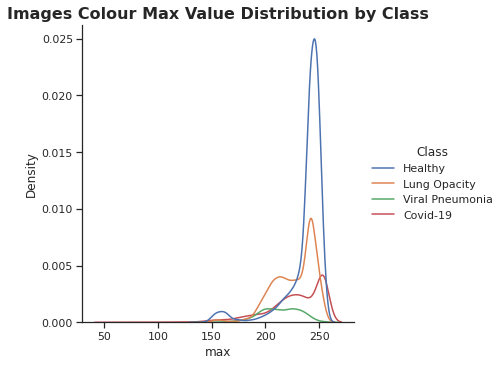

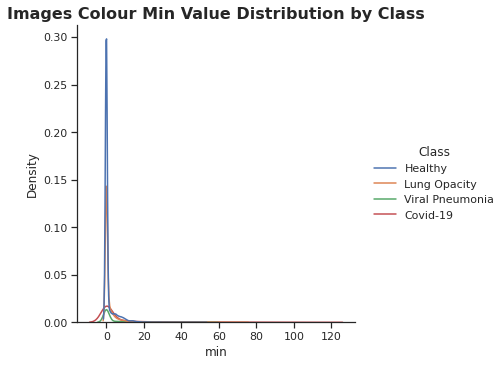

In [13]:
ax = sns.displot(data = imageEDA, x = 'mean', kind="kde");
plt.title('Images Colour Mean Value Distribution', fontsize = 16,weight = 'bold');
ax = sns.displot(data = imageEDA, x = 'mean', kind="kde", hue = 'Class');
plt.title('Images Colour Mean Value Distribution by Class', fontsize = 16,weight = 'bold');
ax = sns.displot(data = imageEDA, x = 'max', kind="kde", hue = 'Class');
plt.title('Images Colour Max Value Distribution by Class', fontsize = 16,weight = 'bold');
ax = sns.displot(data = imageEDA, x = 'min', kind="kde", hue = 'Class');
plt.title('Images Colour Min Value Distribution by Class', fontsize = 16,weight = 'bold');

* The distribution plot of the whole dataset is very similar to the individual Healthy and Lung Opacity images, due to the number of samples of these two classes
* Separating by class we can visualise that the Mean, Max and Min values vary according to the image class
* Viral Pneumonia is the only class that presents a Normal-like distribution across the three different analysis
* The Max value possible for an image is 255. Most classes peak around this number as expected
* Viral Pneumonia is the class that present the most samples with lower Max values if compared to the others. Most samples are within the 200 - 225 range
* Normal (Healthy) and Lung Opacity samples present a very similar distribution of their mean values. Not sure if this could be related to the fact that these classes are the most numerous of the dataset. The different peaks on the distribution could also be because of the image source (e.g. two different hospitals)
* Regarding the Max values, Lung Opacity and Covid-19 present similar  distributions (see the "bumps"), while Normal patients have a peak at 150 and then another peak around 250

Continuing our analysis with the Mean values, now we analyse the relantionship between an image Mean value and its Standard Deviation. 

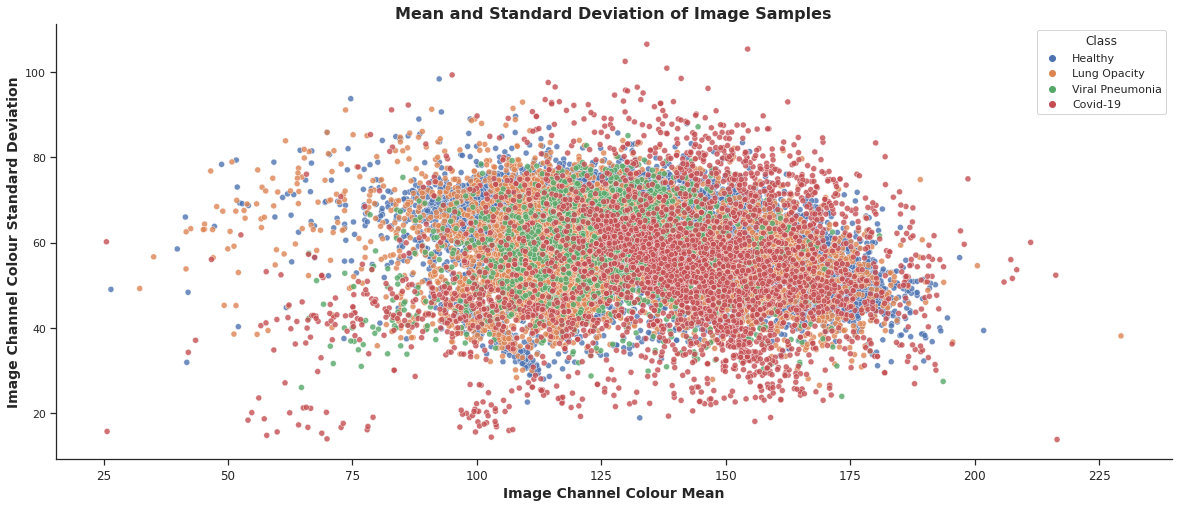

In [14]:
plt.figure(figsize=(20,8))
sns.set(style="ticks", font_scale = 1)
ax = sns.scatterplot(data=imageEDA, x="mean", y=imageEDA['stedev'], hue = 'Class',alpha=0.8);
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Image Channel Colour Mean',fontsize = 14,weight = 'bold')
ax.set_ylabel('Image Channel Colour Standard Deviation',fontsize = 14,weight = 'bold')
plt.title('Mean and Standard Deviation of Image Samples', fontsize = 16,weight = 'bold');

* Most images are gathered in the central region of the scatter plot, i.e. there is not much contrast between their pixel values
* Covid-19 samples seem to be the only class to have a small cluster of data on the bottom left side of the plot, where samples with a lower mean and low standard variation lie
* An individual plot by class is required, as the classes are on top of each other and we might miss important details
* We see that all classes have outliers spread around the peripheric area of the graph. It will be interesting to use visualisation to understand how the outliers look like

The plot above is crowded, let's analyse by class separately:

<Figure size 1440x576 with 0 Axes>

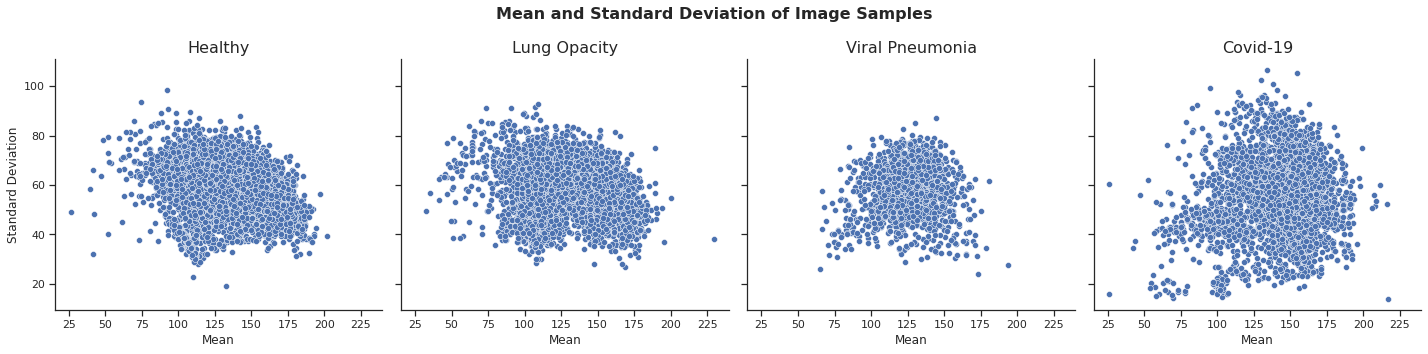

In [15]:
plt.figure(figsize=(20,8));
g = sns.FacetGrid(imageEDA, col="Class",height=5);
g.map_dataframe(sns.scatterplot, x='mean', y='stedev');
g.set_titles(col_template="{col_name}", row_template="{row_name}", size = 16)
g.fig.subplots_adjust(top=.7)
g.fig.suptitle('Mean and Standard Deviation of Image Samples',fontsize=16, weight = 'bold')
axes = g.axes.flatten()
axes[0].set_ylabel('Standard Deviation');
for ax in axes:
    ax.set_xlabel('Mean')
g.fig.tight_layout()

* The Normal (Healthy) samples and Lung Opacity images have a similar scatter, with most of its outliers with higher standard deviation and lower mean values
* Viral Pneumonia images display a more concentrated scatter, perhaps these images have higher similarity to each other than compared to the other classes
* The Covid-19 scatter does not resemble any of the other three classes. It presents more outliers than the other classes, and the points are more scattered across the graph. It could indicate that the images have a higher distinction between each other

The visualisation below was inspired by a talk at [PyData 2016](https://www.youtube.com/watch?v=GIVK0-SNUgU), by Mehrdad Yazdani with the title *Using Exploratory Data Analysis to Discover Patterns*. It really helps to make things clearer to see the images data into a chart format. The dots location of the scatter plot above are used as reference for the image locations.

>Due to the time it takes to load, 10% of data is used for the visualisation. 

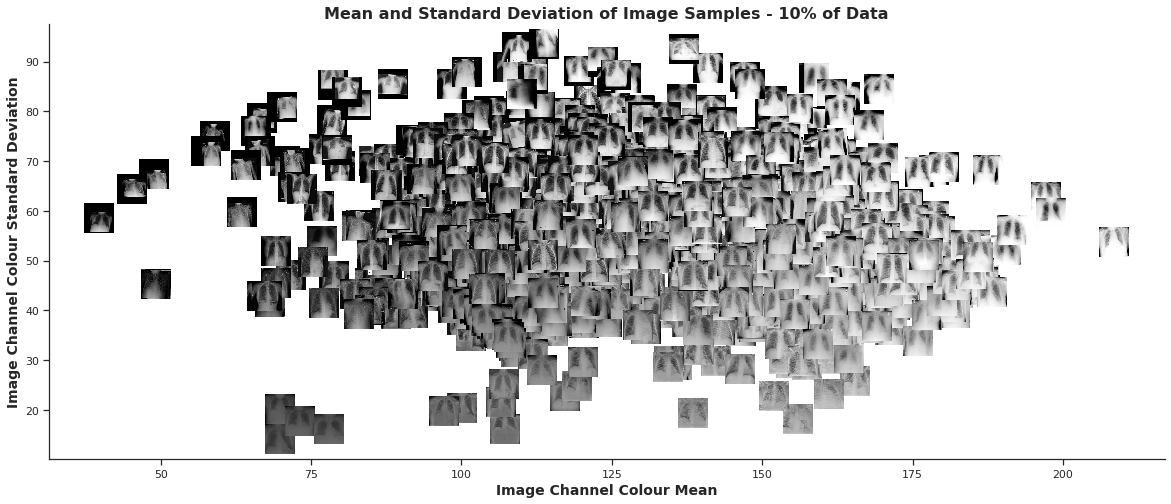

In [16]:
def getImage(path):
    return OffsetImage(cv2.imread(path),zoom = 0.1)

DF_sample = imageEDA.sample(frac=0.1, replace=False, random_state=1)
paths = DF_sample['path']

fig, ax = plt.subplots(figsize=(20,8))
ab = sns.scatterplot(data=DF_sample, x="mean", y='stedev')
sns.despine(top=True, right=True, left=False, bottom=False)
ax.set_xlabel('Image Channel Colour Mean',fontsize = 14,weight = 'bold')
ax.set_ylabel('Image Channel Colour Standard Deviation',fontsize = 14,weight = 'bold')
plt.title('Mean and Standard Deviation of Image Samples - 10% of Data', fontsize = 16,weight = 'bold');

for x0, y0, path in zip(DF_sample['mean'], DF_sample['stedev'],paths):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)

* Even though we could use our imagination to understand what it meant to have high or low mean values, the visualisation above really helps to grasp the concept. Following the X-Axis, the images have a crescent brightness increase as they present higher mean values 
* Higher standard deviations are linked to images with high contrast and a more dominant black background 
* The outliers at low standard deviation and near the 75 are from Covid-19. It seems like a little data cluster at that region
* More insights could be available by performing the plot by class

# 3. CNN Model

Basic considerations regarding the CNN model used:
* Use ImageDataGenerator for Data Augmentation and organise the files into training and validation set
* train and val_datagen have different settings. Ideally, we should not augment the validation set
* val_datagen hyperparameter **shuffle=False** makes sure the training and validation data do not overlap
* I used a CNN architecture that has consistently provided me reasonable results as a starting point
* The Model predicts the Four types of X-Ray Images
* Confusion Matrix, Accuracy, Precision, Recall and F-Score are analysed for final remarks

>ImageDataGenerator settings

In [17]:
#add the path general where the classes subpath are allocated
path = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset'

classes=["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"]
#classes=["COVID",  "Normal"]
num_classes = len(classes)
batch_size=32

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


#load the images to training
train_gen = train_datagen.flow_from_directory(directory=path, 
                                              target_size=(299, 299),
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True, classes=classes,
                                              batch_size=batch_size, 
                                              color_mode="grayscale")
#load the images to test
test_gen = val_datagen.flow_from_directory(directory=path, 
                                              target_size=(299, 299),
                                              class_mode='categorical',
                                              subset='validation',
                                              shuffle=False, classes=classes,
                                              batch_size=batch_size, 
                                              color_mode="grayscale")

Found 16933 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.


>CNN Architecture

In [18]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(299, 299, 1)))
model.add(BatchNormalization())
##############################
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
##############################
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
##############################
model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

#Output
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
#metric = PrecisionAtRecall(0.5, num_thresholds=200, name=None, dtype=None)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=[Recall()])

Preliminary tests have shown that model performance was very much impacted by the batch size, more than by the learning rate or optimiser used. 

Batch size is the number of samples processed before the model is updated. Larger batch sizes (32,64,128) provided a lower test set accuracy regardless of the number of epochs. A smaller batch than 16 took longer to train and yielded similar results. 

The validation performance oscillates heavily in the initial epochs, i.e. from 0.00 to 90% in the following epoch. As the Learning Rate was already low, reducing it was not helpful and neither callbacks improved this behaviour. Perhaps, when using 'SGD' as an optimiser I can play with Learning Rate Scheduling. 'Adam' already has that functionality built-in. 

Even though I did not use any optimised hyperparameters tuning, the batch_size with a lower learning rate of 0,001 provided satisfactory results.

> Model settings and training

In [19]:
#Model Parameters
epochs = 1000
batch_size = 16
#Callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=10, verbose=0, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=100,monitor='val_loss', mode = 'min',verbose=0)

# define the checkpoint
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint,learning_rate_reduction,early_stopping_monitor]

history = model.fit(train_gen, steps_per_epoch=len(train_gen) // batch_size, 
                                validation_steps=len(test_gen) // batch_size, 
                                validation_data=test_gen, epochs=epochs,callbacks=[callbacks_list],
                                verbose=1)

y_pred = model.predict(test_gen)

Epoch 1/1000
33/33 [==============================] - 18s 381ms/step - loss: 1.8206 - recall: 0.3612 - val_loss: 0.7812 - val_recall: 0.2305
Epoch 2/1000
33/33 [==============================] - 12s 366ms/step - loss: 1.2592 - recall: 0.4656 - val_loss: 1.6392 - val_recall: 0.0000e+00
Epoch 3/1000
33/33 [==============================] - 12s 375ms/step - loss: 1.1949 - recall: 0.4720 - val_loss: 1.2441 - val_recall: 0.0000e+00
Epoch 4/1000
33/33 [==============================] - 12s 363ms/step - loss: 1.1016 - recall: 0.5161 - val_loss: 3.2876 - val_recall: 0.0000e+00
Epoch 5/1000
33/33 [==============================] - 12s 362ms/step - loss: 0.9757 - recall: 0.5515 - val_loss: 1.2335 - val_recall: 0.0195
Epoch 6/1000
33/33 [==============================] - 12s 367ms/step - loss: 0.9400 - recall: 0.5836 - val_loss: 0.3579 - val_recall: 1.0000
Epoch 7/1000
33/33 [==============================] - 12s 362ms/step - loss: 0.8983 - recall: 0.5583 - val_loss: 1.9586 - val_recall: 0.0000e+

Below is the Model performance during training:

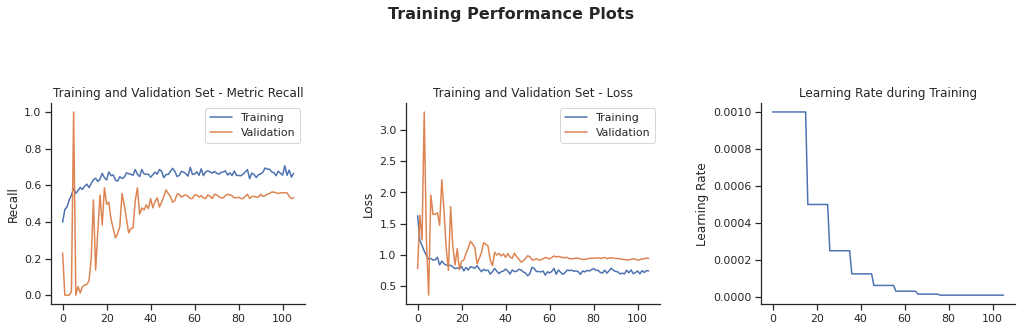

In [58]:
fig, axarr = plt.subplots(1,3, figsize=(15,5),sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

historyDF = pd.DataFrame.from_dict(history.history)
dfs = ['loss','recall','val_loss','val_recall','lr']
ax = sns.lineplot(x =historyDF.index, y = history.history['recall'],ax=axarr[0],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_recall'],ax=axarr[0],label="Validation");
ax.set_ylabel('Recall')
ax = sns.lineplot(x =historyDF.index, y = history.history['loss'],ax=axarr[1],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_loss'],ax=axarr[1],label="Validation");
ax.set_ylabel('Loss')
ax = sns.lineplot(x =historyDF.index, y = history.history['lr'],ax=axarr[2]);
ax.set_ylabel('Learning Rate')    
axarr[0].set_title("Training and Validation Set - Metric Recall")
axarr[1].set_title("Training and Validation Set - Loss")
axarr[2].set_title("Learning Rate during Training")

for ax in axes:
    ax.set_xlabel('Epochs')
    
plt.suptitle('Training Performance Plots',fontsize=16, weight = 'bold');
fig.tight_layout(pad=3.0)      
plt.show()

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
<h3>What we know so far</h3>
<ul>
<li>Peaks and Valleys of the initial training phase indicate several local optima the model has encountered
<li>There is no expressive gain in Model Accuracy Metric after 60 epochs, as we see that the loss for the validation set stabilises after that
<li>The Early Stopping patience needed to be set high (100 epochs) due to the initial peaks in the accuracy of the first runs
<li>Training the model for longer could lead to Overfitting
<li>Training the model for fewer epochs, we would be probably stuck in a Local Optima and fail to generalise to new samples
<li>There is a clear link between the Learning Rate reduction and the model being able to converge to a more stable solution  
<ul>
</blockquote>

# 4. Results and Conclusion

The results are analysed in terms of F1-Score, as Precision and Recall are both relevant metrics for this application. 

To provide a general overview of the Model performance, the confusion matrix and results for the F1-Score, Precision, Recall and overall Accuracy is also presented.

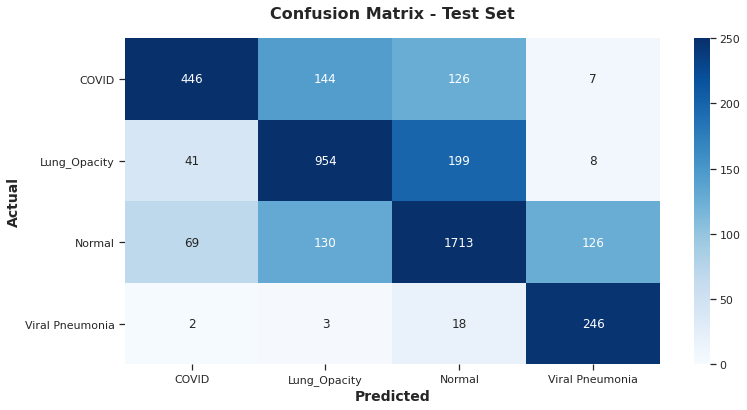

In [61]:
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))
y_true=test_gen.classes
CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)
len(y_true)
plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

keras.backend.clear_session()

* Overall, the model can identify the samples, i.e. there is a good amount of TP
* Covid-19, if misclassified, can be predicted as Lung Opacity or Normal samples. Not likely to be classified as Viral Pneumonia
* Lung Opacity is more often misclassified as Normal than as Viral Pneumonia or Lung Opacity
* Normal samples are usually misclassified as Viral Pneumonia or Lung Opacity. Less common to be mistaken for Covid-19
* Viral Pneumonia is the class with the fewer number of misclassifications

Accuracy Result: 79.37%
Precision Result: 76.08%
Recall Result: 79.14%
F-Score Result: 76.68%


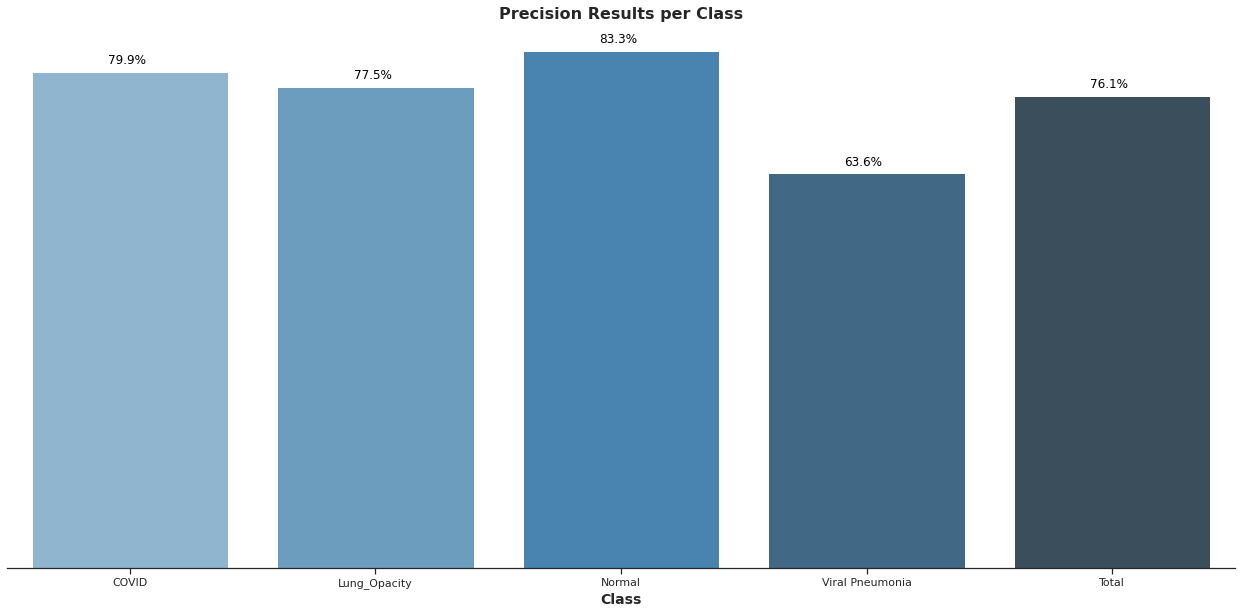

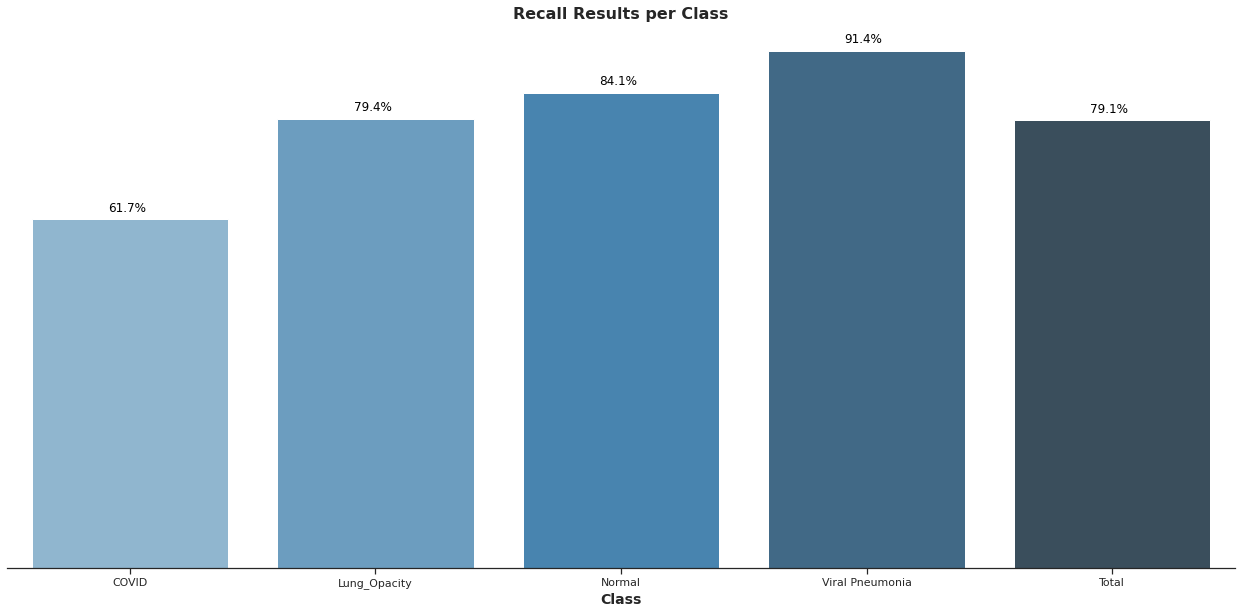

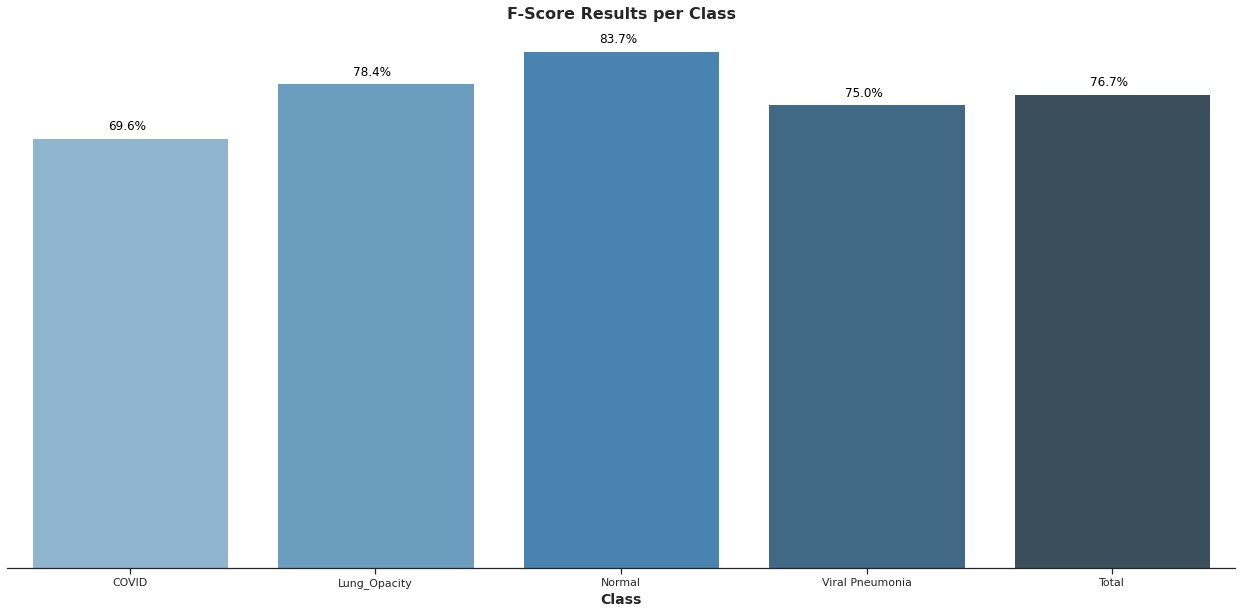

In [59]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

acc = accuracy_score(y_true, predictions)
results_all = precision_recall_fscore_support(y_true, predictions, average='macro',zero_division = 1)
results_class = precision_recall_fscore_support(y_true, predictions, average=None, zero_division = 1)

metric_columns = ['Precision','Recall', 'F-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia','Total']

def metrics_plot(df,metric):
    plt.figure(figsize=(22,10))
    ax = sns.barplot(data =df, x=df.index, y = metric,palette = "Blues_d")
    #Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14,weight = 'bold')
    ax.set_ylabel(metric,fontsize = 14,weight = 'bold')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 16,weight = 'bold');
    
metrics_plot(all_df, 'Precision')
metrics_plot(all_df, 'Recall')
metrics_plot(all_df, 'F-Score')
print('Accuracy Result: %.2f%%'%(acc*100))
print('Precision Result: %.2f%%'%(all_df.iloc[4,0]*100))
print('Recall Result: %.2f%%'%(all_df.iloc[4,1]*100))
print('F-Score Result: %.2f%%'%(all_df.iloc[4,2]*100))


<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
<h3>What we achieved so far</h3>
<ul>
<li>Covid class presents ~ 80% Precision and 60% Recall. While the model is not capable of classifying all the Covid-19 samples correctly (low Recall - higher FN) it is usually correct when it does so (higher precision - low FP)
<li>Lung Opacity and Normal classes have a similar value for Precision and Recall, meaning the model is as good at recognising the samples and properly classifying them
<li>Viral Pneumonia presents the opposite result we saw in Covid-19. It presents a higher Recall than Precision. This means that the model produces FN for this class. However, it needs to be improved to properly classify the samples, i.e. reducing the FP for the Viral Pneumonia class
<li>The F-Score is the balance between Precision and Recall. As expected, Lung Opacity and Normal classes have higher scores as their Precision and Recall metrics are similar. Lower results are found for Covid and Viral Pneumonia, as their Precision and Recall metrics differed more intensely. 
<li>Overall, it is a good outcome that all metric scores are above 75%. The recall is higher as it was monitored, alongside the Model Loss, to stop the training process 
<ul>
</blockquote>

# That is it for now, further analysis to continue soon. I hope you enojoyed and found it helpful.